# PROJECT 1

Submitted To: `Dr. Hasan Sajid`                                              

Submitted By: `Usman Zaheer`, Registration Number: `327700`, RIME: `2020`  Subject: `Deep Learning`

### Problem Statement
Write a complete code from scratch for Convolutional Neural Network. 

### Step 1: Importing useful Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math 
from tqdm import tqdm
from os import listdir

### Step 2: Importing dataset from directory

* Number of Classes in given dataset= 8
* Total Images= 17092
* Size of Images= 360x363 (Reduced to 50x50 for ease of computation)

In [4]:
FOLDER_NAME = 'Dataset'
folders = listdir(FOLDER_NAME)
number_of_classes = len(folders)
data_X, data_Y = [], []
for i in range(number_of_classes):
    folder = folders[i]
    print('Folder', i+1, '-', folder)
    images = listdir(FOLDER_NAME + '/' + folder)
    # Walk over images
    for image in images:
        path = FOLDER_NAME + '/' + folder + '/' + image
        # Process Image
        raw = cv2.imread(path)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(gray, (50, 50))
        # Add to data
        data_X.append(img.flatten())
        data_Y.append(i)
# Convert to numpy arrays
X = np.array(data_X)
Y = np.array(data_Y).reshape([-1, 1])
print('Total training examples:', len(X))
print("Total Images", X.shape)
print("Total Labels", Y.shape)

Folder 1 - basophil
Folder 2 - eosinophil
Folder 3 - erythroblast
Folder 4 - ig
Folder 5 - lymphocyte
Folder 6 - monocyte
Folder 7 - neutrophil
Folder 8 - platelet
Total training examples: 17092
Total Images (17092, 2500)
Total Labels (17092, 1)


### Step 3: Defining main functions for the CNN model

#### Step 3.1: Convolution Function

In [54]:
def scratch_convolution(image, filter, bias, stride=1):
    (no_of_filters, no_of_channels_f, f, _) = filter.shape
    number_of_channels_image, image_dim, _ = image.shape 
    out_dim = int((image_dim - f)/stride)+1 
    assert number_of_channels_image == no_of_channels_f
    convolved = np.zeros((no_of_filters,out_dim,out_dim)) 
    #Moving window over the image
    for curr_filter in range(no_of_filters):
        curr_y = out_y = 0
        while curr_y + f <= image_dim:
            curr_x = out_x = 0
            while curr_x + f <= image_dim:
                convolved[curr_filter, out_y, out_x] = np.sum(filter[curr_filter] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_filter]
                curr_x += stride
                out_x += 1
            curr_y += stride
            out_y += 1
    return convolved

#### Step 3.2: Maxpool Function

In [55]:
def scratch_maxpool(image, filter=2, stride=2):
    number_of_channels, h_orig, w_orig = image.shape
    height = int((h_orig - filter)/stride)+1 
    width = int((w_orig - filter)/stride)+1
    downsampled = np.zeros((number_of_channels, height, width)) 
    #Moving window over the image
    for i in range(number_of_channels):
        curr_y = out_y = 0
        while curr_y + filter <= h_orig:
            curr_x = out_x = 0
            while curr_x + filter <= w_orig:
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+filter, curr_x:curr_x+filter])
                curr_x += stride
                out_x += 1
            curr_y += stride
            out_y += 1       
    return downsampled

#### Step 3.3: Softmax Function

In [17]:
def scratch_softmax(scores):
    out = np.exp(scores)
    return out/np.sum(out)

#### Step 3.4: Entropy Loss Function

In [7]:
def scratch_CrossEntropyLoss(probs, label):
    return -np.sum(label * np.log(probs)) 

### Step 4: Initialization of Paramters (Filter's and Weight's)

In [8]:
def scratch_initializeFilter(size, scale = 1.0):
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)
def scratch_initializeWeight(size):
    return np.random.standard_normal(size=size) * 0.01

### Step 5: Backpropagation Function for Convolution and Maxpool

In [56]:
def scratch_convolutionBackward(dconv_prev, conv_in, filter, stride):
    (no_of_filters, number_of_channels_f, f, _) = filter.shape
    (_, orig_dim, _) = conv_in.shape
    dout = np.zeros(conv_in.shape) 
    dfilter = np.zeros(filter.shape)
    dbias = np.zeros((no_of_filters,1))
    for current_filter in range(no_of_filters):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                dfilter[current_filter] += dconv_prev[current_filter, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[current_filter, out_y, out_x] * filter[current_filter] 
                curr_x += stride
                out_x += 1
            curr_y += stride
            out_y += 1
        dbias[current_filter] = np.sum(dconv_prev[current_filter])
    return dout, dfilter, dbias
def nanargmax(arr):
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs 
def scratch_maxpoolBackward(dpool, orig, f, stride):
    (number_of_channels_f, orig_dim, _) = orig.shape
    dout = np.zeros(orig.shape)
    for curr_c in range(number_of_channels_f):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                (a, b) = nanargmax(orig[curr_c, curr_y:curr_y+f, curr_x:curr_x+f])
                dout[curr_c, curr_y+a, curr_x+b] = dpool[curr_c, out_y, out_x]
                curr_x += stride
                out_x += 1
            curr_y += stride
            out_y += 1
    return dout

### Step 6: Complete Model

#### Model Architecture:

    Convolution1--->ReLU--->Maxpool1--->Convolution2--->ReLU--->MaxPool2--->FullyConnectedLayers
    

In [57]:
def scratch_complete_model(image, label, params, conv_stride, pool_filter, pool_stride):
    [f1, f2, w3, w4, b1, b2, b3, b4] = params 
    first_convolution = scratch_convolution(image, f1, b1, conv_stride) 
    first_convolution[first_convolution<=0] = 0 
    pooled1 = scratch_maxpool(first_convolution, pool_filter, pool_stride)
    second_convolution = scratch_convolution(first_convolution, f2, b2, conv_stride) 
    second_convolution[second_convolution<=0] = 0 
    pooled2 = scratch_maxpool(second_convolution, pool_filter, pool_stride) 
    (nf2, dim2, _) = pooled2.shape
    fully_connected = pooled2.reshape((nf2 * dim2 * dim2, 1)) 
    z = w3.dot(fully_connected) + b3
    z[z<=0] = 0 
    out = w4.dot(z) + b4 
    probs = scratch_softmax(out) 
    loss = scratch_CrossEntropyLoss(probs, label) 
    dout = probs - label 
    dw4 = dout.dot(z.T) 
    db4 = np.sum(dout, axis = 1).reshape(b4.shape) 
    dz = w4.T.dot(dout) 
    dz[z<=0] = 0 
    dw3 = dz.dot(fully_connected.T)
    db3 = np.sum(dz, axis = 1).reshape(b3.shape)
    dfully_connected = w3.T.dot(dz) 
    dpool2 = dfully_connected.reshape(pooled2.shape) 
    dsecond_convolution = scratch_maxpoolBackward(dpool2, second_convolution, pool_filter, pool_stride) 
    dsecond_convolution[second_convolution<=0] = 0 
    dpool1, df2, db2 = scratch_convolutionBackward(dsecond_convolution, pooled1, f2, conv_stride)
    dfirst_convolution= scratch_maxpoolBackward(dpool1, first_convolution, pool_filter, pool_stride) 
    dfirst_convolution[first_convolution<=0] = 0
    dimage, df1, db1 = scratch_convolutionBackward(dfirst_convolution, image, f1, conv_stride)
    gradients = [df1, df2, dw3, dw4, db1, db2, db3, db4] 
    return gradients, loss

### Step 7: Adam Gradient Descent for updating paramters 

In [59]:
def scratch_adamGD(batch, no_of_classes, learning_rate, dim, n_c, beta1, beta2, parameters, cost):
    [f1, f2, w3, w4, b1, b2, b3, b4] = parameters
    X = batch[:,0:-1]
    X = X.reshape(len(batch), n_c, dim, dim)
    Y = batch[:,-1] 
    cost_ = 0
    batch_size = len(batch)
    df1 = np.zeros(f1.shape)
    df2 = np.zeros(f2.shape)
    dw3 = np.zeros(w3.shape)
    dw4 = np.zeros(w4.shape)
    db1 = np.zeros(b1.shape)
    db2 = np.zeros(b2.shape)
    db3 = np.zeros(b3.shape)
    db4 = np.zeros(b4.shape)
    v1 = np.zeros(f1.shape)
    v2 = np.zeros(f2.shape)
    v3 = np.zeros(w3.shape)
    v4 = np.zeros(w4.shape)
    bv1 = np.zeros(b1.shape)
    bv2 = np.zeros(b2.shape)
    bv3 = np.zeros(b3.shape)
    bv4 = np.zeros(b4.shape)
    s1 = np.zeros(f1.shape)
    s2 = np.zeros(f2.shape)
    s3 = np.zeros(w3.shape)
    s4 = np.zeros(w4.shape)
    bs1 = np.zeros(b1.shape)
    bs2 = np.zeros(b2.shape)
    bs3 = np.zeros(b3.shape)
    bs4 = np.zeros(b4.shape)
    for i in range(batch_size):
        x = X[i]
        y = np.eye(no_of_classes)[int(Y[i])].reshape(no_of_classes, 1) # convert label to one-hot
        grads, loss = scratch_complete_model(x, y, parameters, 1, 2, 2)
        [df1_, df2_, dw3_, dw4_, db1_, db2_, db3_, db4_] = grads
        df1+=df1_
        db1+=db1_
        df2+=df2_
        db2+=db2_
        dw3+=dw3_
        db3+=db3_
        dw4+=dw4_
        db4+=db4_
        cost_+= loss
    v1 = beta1*v1 + (1-beta1)*df1/batch_size # momentum update
    s1 = beta2*s1 + (1-beta2)*(df1/batch_size)**2 # RMSProp update
    f1 -= learning_rate * v1/np.sqrt(s1+1e-7) # combine momentum and RMSProp to perform update with Adam 
    bv1 = beta1*bv1 + (1-beta1)*db1/batch_size
    bs1 = beta2*bs1 + (1-beta2)*(db1/batch_size)**2
    b1 -= learning_rate * bv1/np.sqrt(bs1+1e-7)
    v2 = beta1*v2 + (1-beta1)*df2/batch_size
    s2 = beta2*s2 + (1-beta2)*(df2/batch_size)**2
    f2 -= learning_rate * v2/np.sqrt(s2+1e-7)                 
    bv2 = beta1*bv2 + (1-beta1) * db2/batch_size
    bs2 = beta2*bs2 + (1-beta2)*(db2/batch_size)**2
    b2 -= learning_rate * bv2/np.sqrt(bs2+1e-7)
    v3 = beta1*v3 + (1-beta1) * dw3/batch_size
    s3 = beta2*s3 + (1-beta2)*(dw3/batch_size)**2
    w3 -= learning_rate * v3/np.sqrt(s3+1e-7)
    bv3 = beta1*bv3 + (1-beta1) * db3/batch_size
    bs3 = beta2*bs3 + (1-beta2)*(db3/batch_size)**2
    b3 -= learning_rate * bv3/np.sqrt(bs3+1e-7)
    v4 = beta1*v4 + (1-beta1) * dw4/batch_size
    s4 = beta2*s4 + (1-beta2)*(dw4/batch_size)**2
    w4 -= learning_rate * v4 / np.sqrt(s4+1e-7)
    bv4 = beta1*bv4 + (1-beta1)*db4/batch_size
    bs4 = beta2*bs4 + (1-beta2)*(db4/batch_size)**2
    b4 -= learning_rate * bv4 / np.sqrt(bs4+1e-7)
    cost_ = cost_/batch_size
    cost.append(cost_)
    parameters = [f1, f2, w3, w4, b1, b2, b3, b4]
    return parameters, cost

## Annex B

### Training Code

### Step 8: Training the model

Training the model using following paramters:
    
* Number of classes= 8 (In given dataset)
* Learning Rate= 0.001
* beta1= 0.95 (Variable for AdamGD)
* beta2= 0.99 (Variable for AdamGD)
* img_dim= 50*50 (For ease of computation)
* f= 5*5 (filter size) 
* num_filter= 10 (Number of filters in each convolution)
* batch_size= 32
* Number of Epochs=1

In [60]:
def scratch_train(no_of_classes = 8, learning_rate = 1e-3, beta1 = 0.95, beta2 = 0.99, img_dim = 50, img_depth = 1, 
                  f = 5, num_filt1 = 10, num_filt2 = 10, batch_size = 32, num_epochs = 10):
    data = np.hstack((X,Y))
    np.random.shuffle(data)
    data_train = round(0.8*len(data))
    data_test = round(data_train+0.2*len(data))
    train_x = X[:data_train]
    print("Shape of train data",train_x.shape)
    test_x = X[data_train:data_test]
    print("Shape of test data",test_x.shape)
    train_y = Y[:data_train]
    test_y = Y[data_train:data_test]
    train_data = np.hstack((train_x,train_y))
    test_data = np.hstack((test_x,test_y))
    train_data1= train_data[:10000]
    test_data1=  test_data[:3000]
    ## Initializing all the parameters
    f1, f2, w3, w4 = (num_filt1 ,img_depth,f,f), (num_filt2 ,num_filt1,f,f), (96,4410), (8, 96)
    f1 = scratch_initializeFilter(f1)
    f2 = scratch_initializeFilter(f2)
    w3 = scratch_initializeWeight(w3)
    w4 = scratch_initializeWeight(w4)
    b1 = np.zeros((f1.shape[0],1))
    b2 = np.zeros((f2.shape[0],1))
    b3 = np.zeros((w3.shape[0],1))
    b4 = np.zeros((w4.shape[0],1))
    parameters = [f1, f2, w3, w4, b1, b2, b3, b4]
    train_cost = []
    train_cost1=[]
    test_cost = []
    test_cost1=[]
    print("Learning Rate:"+str(learning_rate)+", Batch Size:"+str(batch_size))

    for epoch in range(num_epochs):
        np.random.shuffle(train_data1)
        batches = [train_data1[k:k + batch_size] for k in range(0, train_data1.shape[0], batch_size)]

        np.random.shuffle(test_data1)
        batches1 = [test_data1[k:k + batch_size] for k in range(0, test_data1.shape[0], batch_size)]

        t = tqdm(batches)
        for x,batch in enumerate(t):
            parameters, train_cost = scratch_adamGD(batch, no_of_classes, learning_rate, img_dim, img_depth, beta1, beta2, parameters, train_cost)
            t.set_description("Training_Cost: %.2f" % (train_cost[-1]))
        train_cost1.append(train_cost)
        
        t1 = tqdm(batches1)
        for x,batch in enumerate(t1):
            parameters1, test_cost = scratch_adamGD(batch, no_of_classes, learning_rate, img_dim, img_depth, beta1, beta2, parameters, test_cost)
            t1.set_description("Test_Cost: %.2f" % (test_cost[-1]))   
        test_cost1.append(test_cost)

    print ("parameters", parameters)
    
    return parameters, train_cost1,test_cost1

In [20]:
parameters, train_cost, test_cost = scratch_train(no_of_classes = 8, learning_rate = 1e-3, beta1 = 0.95, beta2 = 0.99, img_dim = 50, img_depth = 1, f = 5, num_filt1 = 10, num_filt2 = 10, batch_size = 32, num_epochs = 1)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Shape of train data (13674, 2500)
Shape of test data (3418, 2500)
Learning Rate:0.001, Batch Size:32


Test_Cost: 4.84: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.59s/it]

parameters [array([[[[-3.43161381e-02, -1.71865968e-02,  4.87401721e-02,
           6.71562385e-02, -9.36512718e-02],
         [ 3.04725110e-02,  1.46588408e-02, -3.48094301e-02,
          -7.29805905e-02, -9.27759021e-03],
         [-9.71830337e-02, -6.20195629e-02, -4.24281739e-02,
           1.40831489e-01, -2.88058056e-02],
         [ 6.32434419e-02,  5.89043919e-02,  2.19285094e-02,
          -2.51980673e-02,  1.18595915e-01],
         [-6.15383133e-02,  5.45615672e-02, -1.88634217e-02,
          -8.70111725e-02,  2.41282638e-02]]],


       [[[ 6.07430280e-02,  4.22611694e-03,  2.17105904e-02,
           4.51616516e-03, -8.64859697e-02],
         [ 2.00938320e-02, -1.48476730e-03,  7.32233054e-02,
           2.57000925e-02,  5.09058981e-02],
         [-5.68124062e-02,  2.98699316e-02, -1.32659697e-02,
          -5.14879286e-03,  6.52064777e-02],
         [ 4.84485511e-02, -5.16583253e-03,  1.01280670e-01,
          -1.43107639e-01,  5.55647717e-03],
         [ 3.74910138e-02, -8.

### Step 9: Saving the updated paramters

In [24]:
filter1= parameters[0].flatten()
filter2= parameters[1].flatten()
weight3= parameters[2].flatten()
weight4= parameters[3].flatten()
bias1= parameters[4].flatten()
bias2= parameters[5].flatten()
bias3= parameters[6].flatten()
bias4= parameters[7].flatten()

In [51]:
print("f1=", filter1.shape) 
print("f2=", filter2.shape) 
print("w3=", weight3.shape)
print("w4=", weight4.shape)
print("b1=", bias1.shape)
print("b2=", bias2.shape)
print("b3=", bias3.shape)
print("b4=", bias4.shape)

f1= (250,)
f2= (2500,)
w3= (423360,)
w4= (768,)
b1= (10,)
b2= (10,)
b3= (96,)
b4= (8,)


In [26]:
f11 = np.savetxt('filter1.txt', filter1, delimiter=', ')
f22 = np.savetxt('filter2.txt', filter2, delimiter=', ')
w33 = np.savetxt('weight3.txt', weight3, delimiter=', ')
w44 = np.savetxt('weight4.txt', weight4, delimiter=', ')
b11 = np.savetxt('bias1.txt', bias1, delimiter=', ')
b22 = np.savetxt('bias2.txt', bias2, delimiter=', ')
b22 = np.savetxt('bias3.txt', bias3, delimiter=', ')
b33 = np.savetxt('bias4.txt', bias4, delimiter=', ')

### Step :9 Data Visualization 

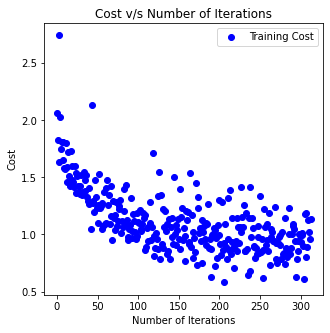

In [86]:
fig,(ax1)=plt.subplots(figsize=(5,5),nrows=1,ncols=1)
ax1.scatter(x=list(range(0,313)),y=train_cost[0],color='blue',label='Training Cost')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title('Cost v/s Number of Iterations')
plt.legend()
plt.show()

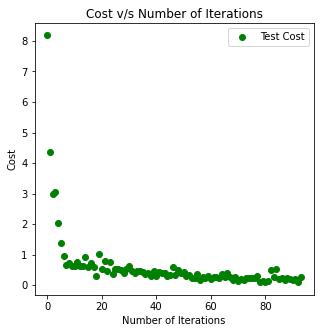

In [87]:
fig,(ax1)=plt.subplots(figsize=(5,5), nrows=1,ncols=1)
ax1.scatter(x=list(range(0,94)),y=test_cost[0],color='green',label='Test Cost')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title('Cost v/s Number of Iterations')
plt.legend()
plt.show()

#### Test Image from Dataset

Text(0.5, 0, 'Basophil')

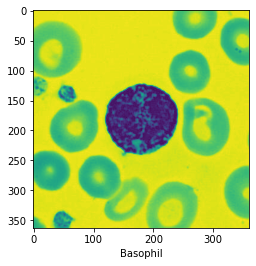

In [36]:
image= cv2.imread("BA_47.jpg",0)
plt.imshow(image)
plt.xlabel("Basophil")

In [37]:
image= cv2.resize(image,(50,50),interpolation = cv2.INTER_AREA)

In [38]:
image=np.reshape(image, (1,50,50))

In [39]:
image.shape

(1, 50, 50)

 ### Using Optimized Paramters in Prediction Function for finding accuracy on test set.

In [61]:
def scratch_predict(image, f1, f2, w3, w4, b1, b2, b3, b4, conv_stride = 1, pool_filter = 2, pool_stride = 2):
    first_convolution = scratch_convolution(image, f1, b1, conv_stride) 
    first_convolution[first_convolution<=0] = 0 
    pooled1 = scratch_maxpool(first_convolution, pool_filter, pool_stride)
    second_convolution = scratch_convolution(first_convolution, f2, b2, conv_stride) 
    second_convolution[second_convolution<=0] = 0 
    pooled2 = scratch_maxpool(second_convolution, pool_filter, pool_stride) 
    (nf2, dim2, _) = pooled2.shape
    fully_connected = pooled2.reshape((nf2 * dim2 * dim2, 1)) 
    z = w3.dot(fully_connected) + b3
    z[z<=0] = 0 
    out = w4.dot(z) + b4 
    probs = scratch_softmax(out)  
    return np.argmax(probs), np.max(probs)

In [50]:
    data = np.hstack((X,Y))
    np.random.shuffle(data)
    data_train = round(0.8*len(data))
    data_test = round(data_train+0.2*len(data))
    test_x = X[data_train:data_test]
    test_y = Y[data_train:data_test] 
    test_data = np.hstack((test_x,test_y))
    np.random.shuffle(test_data)
    test_x = test_x.reshape(len(test_data), 1, 50, 50)
    print("Shape of test data",test_x.shape)
    corr = 0
    counter = [0 for i in range(10)]
    correct_predictions = [0 for i in range(10)]
    print()
    print("Computing accuracy over test set:")
    t = tqdm(range(len(test_x)), leave=True)
    f1=parameters[0]
    f2=parameters[1]
    w3=parameters[2]
    w4=parameters[3] 
    b1=parameters[4]
    b2=parameters[5]
    b3=parameters[6]
    b4=parameters[7]
    for i in t:
        x = test_x[i]
        pred, prob = scratch_predict(x, f1, f2, w3, w4, b1, b2, b3, b4)
        counter[int(test_y[i])]+=1
        if pred==test_y[i]:
            corr+=1
            correct_predictions[pred]+=1

        t.set_description("Acc:%0.2f%%" % (float(corr/(i+1))*100))
        
    print("Overall Accuracy: %.2f" % (float(corr/len(test_x)*100)))

  0%|                                                                                         | 0/3418 [00:00<?, ?it/s]

Shape of test data (3418, 1, 50, 50)

Computing accuracy over test set:


Acc:31.30%: 100%|████████████████████████████████████████████████████████████████| 3418/3418 [1:07:56<00:00,  1.19s/it]

Overall Accuracy: 31.30
